## Data Plots

This notebook performs the fits to data that are shown in the paper. 

The data points are taken from simulated halo shapes as measured in Akitsu et al (2023).

In [1]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

## Load Data

In [2]:
def load_spin_data(M1, M2, dk = 0.005, Vobs = 1.5**3 * 1e9):

    kdats = np.loadtxt('../data/power_RS_reduced_%s_%s_z0.51_%s.dat'%(M1,M2,20))[:,0]
    Pshot = np.loadtxt('../data/shot_RS_reduced_%s_%s_z0.51.dat'%(M1,M2))[()]

    spectra = {}
    errs = {}

    helicities = ['20', '21m', '21p', '22m', '22p']

    for helicity in helicities:
        spectra[helicity] = np.loadtxt('../data/power_RS_reduced_%s_%s_z0.51_%s.dat'%(M1,M2,helicity))[:,1] - 2*Pshot
        errs[helicity] = np.loadtxt('../data/power_RS_reduced_%s_%s_z0.51_%s.dat'%(M1,M2,helicity))[:,2]
        
    spectra['21'] = (spectra['21p'] + spectra['21m'])/2
    errs['21'] = (errs['21p'] + errs['21m'])/2/np.sqrt(2)

    spectra['22'] = (spectra['22p'] + spectra['22m'])/2
    errs['22'] = (errs['22p'] + errs['22m'])/2/np.sqrt(2)

    dvec = np.concatenate( (spectra['20'],spectra['21'],spectra['22']))

    Nk =  8 * Vobs * kdats**2 * dk / (2*np.pi**2)
    cov = 2 * np.diag( (2*Pshot + np.concatenate((spectra['20'], spectra['21'], spectra['22']) ) )**2 )
    cov /= np.concatenate( (Nk, 2*Nk, 2*Nk))
    cinv = np.linalg.inv(cov)
    dcov = np.diag(cov)
    
    return kdats, spectra, errs, dvec, dcov, Pshot

In [3]:
M1, M2 = '1e12', '3.16e12'

#M1, M2 = '3.16e12', '1e13'

M1, M2 = '1e13', '3.16e13'

kdats, spectra, errs, dvec, dcov, Pshot = load_spin_data(M1,M2)

## Compute Theory

In [4]:
from scipy.special import hyp2f1
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def D_of_a(a,OmegaM=0.3089):
    return a * hyp2f1(1./3,1,11./6,-a**3/OmegaM*(1-OmegaM)) / hyp2f1(1./3,1,11./6,-1/OmegaM*(1-OmegaM))

z = 0.51
Dz = D_of_a(1./(1+z))

klin, plin = np.loadtxt('../data/power_lin.dat', unpack=True); plin *= Dz**2

In [5]:
import sys
sys.path.append('../')
from spinosaurus.shape_shape_correlators_fftw import ShapeShapeCorrelators
from spinosaurus.Utils.loginterp import loginterp

In [6]:
lpt = ShapeShapeCorrelators(klin, plin, kIR=0.2, one_loop=True, N=2000, jn=15)

pktable0 = lpt.make_ggtable(0,kmin=5e-3, kmax=0.31, nk=200)
pktable1 = lpt.make_ggtable(1,kmin=5e-3, kmax=0.31, nk=200)
pktable2 = lpt.make_ggtable(2,kmin=5e-3, kmax=0.31, nk=200)

In [7]:
def curve_func(k, c_s, c_ds, c_s2, c_L2, c_3, c_dt, alpha_s1, sn, sn21, sn22):
        
    bvec = [c_s, c_ds, c_s2, c_L2, c_3, c_dt, alpha_s1, sn]
    
    P0 = interp1d(*lpt.combine_bias_terms_shape_shape(0, bvec[:-1], bvec[:-1], Pshot=bvec[-1]),kind='cubic')(k)
    P1 = interp1d(*lpt.combine_bias_terms_shape_shape(1, bvec[:-1], bvec[:-1], Pshot=bvec[-1]),kind='cubic')(k)
    P2 = interp1d(*lpt.combine_bias_terms_shape_shape(2, bvec[:-1], bvec[:-1], Pshot=bvec[-1]),kind='cubic')(k)
    
    P0 += sn21 * k**2
    P1 += (sn21 + sn22) * k**2
    P2 += (sn21 + 4*sn22) * k**2
    
    return np.concatenate( (P0, P1, P2) )

def curve_func_nok2(k, c_s, c_ds, c_s2, c_L2, c_3, c_dt, alpha_s1, sn):
        
    bvec = [c_s, c_ds, c_s2, c_L2, c_3, c_dt, alpha_s1, sn]
    
    P0 = interp1d(*lpt.combine_bias_terms_shape_shape(0, bvec[:-1], bvec[:-1], Pshot=bvec[-1]),kind='cubic')(k)
    P1 = interp1d(*lpt.combine_bias_terms_shape_shape(1, bvec[:-1], bvec[:-1], Pshot=bvec[-1]),kind='cubic')(k)
    P2 = interp1d(*lpt.combine_bias_terms_shape_shape(2, bvec[:-1], bvec[:-1], Pshot=bvec[-1]),kind='cubic')(k)
    
    return np.concatenate( (P0, P1, P2) )

def curve_func_local(k, c_s, c_ds,  alpha_s1, sn, sn21, sn22):
        
    bvec = [c_s, c_ds, 0, 0, 0, 0, alpha_s1, sn]
    
    P0 = interp1d(*lpt.combine_bias_terms_shape_shape(0, bvec[:-1], bvec[:-1], Pshot=bvec[-1]),kind='cubic')(k)
    P1 = interp1d(*lpt.combine_bias_terms_shape_shape(1, bvec[:-1], bvec[:-1], Pshot=bvec[-1]),kind='cubic')(k)
    P2 = interp1d(*lpt.combine_bias_terms_shape_shape(2, bvec[:-1], bvec[:-1], Pshot=bvec[-1]),kind='cubic')(k)
    
    P0 += sn21 * k**2
    P1 += (sn21 + sn22) * k**2
    P2 += (sn21 + 4*sn22) * k**2
    
    return np.concatenate( (P0, P1, P2) )

## Make Plots

0 1e12 3.16e12
0.050149895785633836
0.050149895785633836
0.05016165420622181 -0.0005721031144290003 0.0035766603833714207 0.071506711777741 -0.8221604956326556 0.12058485148769758
1 1e13 3.16e13
0.08422130335956211
0.08422130335956211


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0.08560672538828638 0.07419764894605413 0.013822806268764887 0.05045509076737922 -6.72348244803704 2.420244528097296


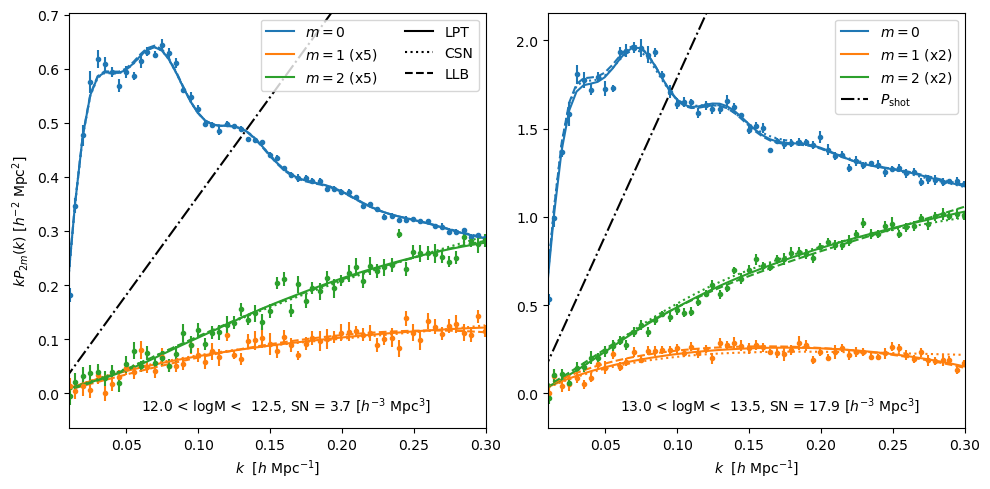

In [8]:
mfacs = [5,2]

plt.figure(figsize=(10,5))

for ii, (M1, M2) in enumerate([ ('1e12', '3.16e12'), ('1e13', '3.16e13') ]):

    print(ii, M1,M2)
    
    m1fac = mfacs[ii]
    m2fac = mfacs[ii]
    
    kdats, spectra, errs, dvec, dcov, Pshot = load_spin_data(M1,M2)
    
    iis = (kdats > 0.02) * (kdats < 0.3)

    xdat = kdats[iis]
    ydat = np.concatenate( (spectra['20'][iis], spectra['21'][iis], spectra['22'][iis]))
    sigmas = np.sqrt(dcov)[np.concatenate((iis,iis,iis))]

    res = curve_fit(curve_func, xdat, ydat, sigma=sigmas)
    print(res[0][0])

    ps = curve_func(kdats, *res[0])
    p0 = ps[:60]
    p1 = ps[60:120]
    p2 = ps[120:]
    print(res[0][0])

    
    res = curve_fit(curve_func_nok2, xdat, ydat, sigma=sigmas)
    ps = curve_func_nok2(kdats, *res[0])
    p0_nok2 = ps[:60]
    p1_nok2 = ps[60:120]
    p2_nok2 = ps[120:]
    
    res = curve_fit(curve_func_local, xdat, ydat, sigma=sigmas)
    print(*res[0])
    ps = curve_func_local(kdats, *res[0])
    p0_local = ps[:60]
    p1_local = ps[60:120]
    p2_local = ps[120:]
    
    plt.subplot(1,2,ii+1)

    plt.errorbar(kdats, kdats * spectra['20'], yerr=kdats*errs['20'],fmt='.',c='C0' )
    plt.errorbar(kdats, m1fac * kdats * spectra['21'], yerr=m1fac * kdats*errs['21'], fmt='.',c='C1' )
    plt.errorbar(kdats, m2fac * kdats * spectra['22'], yerr=m2fac * kdats*errs['22'], fmt='.',c='C2' )

    plt.plot(kdats, kdats * p0,label=r'$m=0$')
    plt.plot(kdats, m1fac * kdats * p1,label=r'$m=1$ (x%d)'%(m1fac))
    plt.plot(kdats, m2fac * kdats * p2,label=r'$m=2$ (x%d)'%(m2fac))

    plt.plot(kdats, kdats * p0_nok2,'C0:')
    plt.plot(kdats, m1fac * kdats * p1_nok2,'C1:')
    plt.plot(kdats, m2fac * kdats * p2_nok2,'C2:')
    
    plt.plot(kdats, kdats * p0_local,'C0--')
    plt.plot(kdats, m1fac * kdats * p1_local,'C1--')
    plt.plot(kdats, m2fac * kdats * p2_local,'C2--')
    
    plt.plot(kdats, kdats * Pshot, 'k-.')
    
    plt.xlim(0.01,0.3)
    plt.ylim(-0.1 * np.max(kdats*p0), 1.1 * np.max(kdats*p0))
    
    plt.text(0.06, -0.05 * np.max(kdats*p0), r'%.1f < logM <  %.1f, SN = %.1f [$h^{-3}$ Mpc$^3$]'%(np.log10(float(M1)),np.log10(float(M2)),Pshot))

    plt.xlabel(r'$k$  [$h$ Mpc$^{-1}$]')
    if ii==0:
        plt.ylabel(r'$k P_{2m}(k)$ [$h^{-2}$ Mpc$^2$]')
    
    if ii==0:
        plt.plot(0,0,'k',label='LPT')
        plt.plot(0,0,'k:',label=r'CSN')
        plt.plot(0,0,'k--',label=r'LLB')
        plt.legend(loc='upper right',ncol=2)
    else:
        plt.plot(0,0,'k-.',label=r'$P_{\rm shot}$')
        plt.legend(loc='upper right')
    
plt.tight_layout()

#plt.savefig('fits_to_data.pdf')